# Setup

In [1]:
!pip install rasterio

     |████████████████████████████████| 18.3MB 244kB/s 


In [2]:
!pip install pygeos

     |████████████████████████████████| 1.6MB 9.5MB/s 


In [3]:
!pip install geopandas

     |████████████████████████████████| 972kB 7.1MB/s 
     |████████████████████████████████| 14.8MB 330kB/s 
     |████████████████████████████████| 6.5MB 47.8MB/s 


In [4]:
!pip install owslib

     |████████████████████████████████| 204kB 8.0MB/s 


# Exercises
- clip the area with the shape of Polo Ferrari (in front on FBK)
- create the altitude profile of the street “Via Sommarive”
- find the area FBK in the WMS of municipality of Trento - layer “Carta Tecnica 1:2.000 alta risoluzione” and vectorize it
---


## clip the area with the shape of Polo Ferrari (in front on FBK)
1. identify the area of Polo Ferrari
2. download the raster of scientific hub in Povo
3. clip area

In [5]:
import geopandas as gpd
import rasterio 
from rasterio.mask import mask
from rasterio.plot import show

/usr/local/lib/python3.6/dist-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### 1. identify the area of Polo Ferrari

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/polo_ferrari_overpassturbo.png)

http://overpass-turbo.eu/s/ZzP


[geojson](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/openstreetmap/polo_ferrari_boundary.geojson)



In [6]:
geojson_polo_ferarri = "https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/openstreetmap/polo_ferrari_boundary.geojson"

In [7]:
polo_ferrari = gpd.read_file(geojson_polo_ferarri)

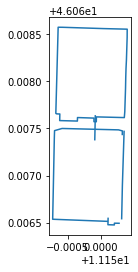

In [8]:
polo_ferrari.plot()

In [9]:
polo_ferrari.geometry.type.unique()

array(['LineString'], dtype=object)

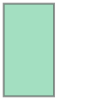

In [10]:
polo_ferrari.geometry.unary_union.envelope

In [11]:
area_polo_ferrari = polo_ferrari.geometry.unary_union.envelope

In [12]:
type(area_polo_ferrari)

shapely.geometry.polygon.Polygon

### 2. download the raster of scientific hub in Povo


In [13]:
!wget https://github.com/napo/geospatial_course_unitn/raw/master/data/raster/trento_scientifc_hub_povo.tif

--2020-11-07 19:42:59--  https://github.com/napo/geospatial_course_unitn/raw/master/data/raster/trento_scientifc_hub_povo.tif
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/raster/trento_scientifc_hub_povo.tif [following]
--2020-11-07 19:42:59--  https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/raster/trento_scientifc_hub_povo.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8279208 (7.9M) [application/octet-stream]
Saving to: ‘trento_scientifc_hub_povo.tif’

trento_scientifc_hu 100%[===================>]   7.90M  37.9MB/s    in 0

In [14]:
file_scientific_hub_povo = "trento_scientifc_hub_povo.tif"

In [15]:
raster = rasterio.open(file_scientific_hub_povo)

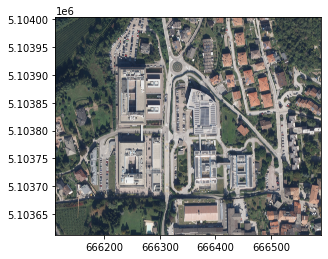

In [16]:
show(raster)

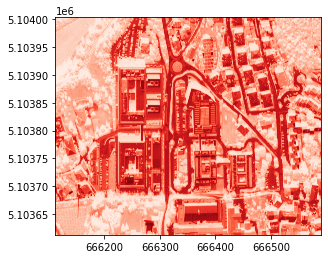

In [17]:
ax = show((raster, 1), cmap='Reds')
ax.set_axis_off()

In [18]:
raster.meta

{'count': 3,
 'crs': CRS.from_epsg(25832),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 3900,
 'nodata': None,
 'transform': Affine(0.09999999999999999, 0.0, 666113.0,
       0.0, -0.09999999999999999, 5104003.0),
 'width': 4761}

### 3. clip area

In [19]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


In [20]:
gdf_polo_ferrari_25832 = gpd.GeoSeries([area_polo_ferrari]).set_crs("EPSG:4326").to_crs("EPSG:25832")

In [21]:
coords = getFeatures(gdf_polo_ferrari_25832)

In [22]:
coords

[{'coordinates': [[[666221.9300357221, 5103679.093307299],
    [666310.1180686228, 5103681.477369573],
    [666303.8138183788, 5103914.6097356975],
    [666215.6291314249, 5103912.225679764],
    [666221.9300357221, 5103679.093307299]]],
  'type': 'Polygon'}]

In [23]:
raster_polo_ferrari, raster_polo_ferrari_transform = mask(raster, coords, crop=True)

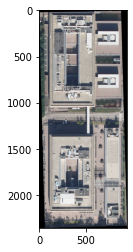

In [24]:
show(raster_polo_ferrari)

In [25]:
raster_polo_ferrari_meta = raster.meta

In [26]:
raster_polo_ferrari_meta.update({"driver": "GTiff",
                 "height": raster_polo_ferrari.shape[1],
                 "width": raster_polo_ferrari.shape[2],
                 "transform": raster_polo_ferrari_transform})

with rasterio.open("polo_ferrari_orthophoto.tif", "w", **raster_polo_ferrari_meta) as dest:
    dest.write(raster_polo_ferrari)

In [27]:
!ls -lah polo_ferrari_orthophoto.tif

-rw-r--r-- 1 root root 6.4M Nov  7 19:43 polo_ferrari_orthophoto.tif


## create the altitude profile of the street “Via Sommarive”
1. download the street "Via Sommarive" from OpenStreetMap
1. download the DTM file of the scientific hub of Povo
1. clip the street inside the area covered of the DTM
1. extract the points of the street
1. extract the altitude value for each points
1. show the altitude
---


### 1. download the street "Via Sommarive" from OpenStreetMap

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/via_sommarive_overpassturbo.png)

http://overpass-turbo.eu/s/ZA0

[geojson](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/openstreetmap/via_sommarive.geojson)

In [28]:
via_sommarive = gpd.read_file("https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/openstreetmap/via_sommarive.geojson")

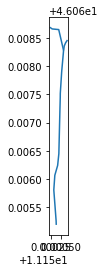

In [29]:
via_sommarive.plot()

### 2. download the DTM file of the scientific hub of Povo

In [30]:
!wget https://github.com/napo/geospatial_course_unitn/raw/master/data/raster/trento_scientifc_hub_povo_dtm.asc

--2020-11-07 19:43:05--  https://github.com/napo/geospatial_course_unitn/raw/master/data/raster/trento_scientifc_hub_povo_dtm.asc
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/raster/trento_scientifc_hub_povo_dtm.asc [following]
--2020-11-07 19:43:06--  https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/raster/trento_scientifc_hub_povo_dtm.asc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 820541 (801K) [text/plain]
Saving to: ‘trento_scientifc_hub_povo_dtm.asc’

trento_scientifc_hu 100%[===================>] 801.31K  --.-KB/s    in 

In [31]:
!wget https://github.com/napo/geospatial_course_unitn/raw/master/data/raster/trento_scientifc_hub_povo_dtm.prj

--2020-11-07 19:43:06--  https://github.com/napo/geospatial_course_unitn/raw/master/data/raster/trento_scientifc_hub_povo_dtm.prj
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/raster/trento_scientifc_hub_povo_dtm.prj [following]
--2020-11-07 19:43:06--  https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/raster/trento_scientifc_hub_povo_dtm.prj
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 403 [text/plain]
Saving to: ‘trento_scientifc_hub_povo_dtm.prj’

trento_scientifc_hu 100%[===================>]     403  --.-KB/s    in 0s      



In [32]:
dtm = "trento_scientifc_hub_povo_dtm.asc"

In [33]:
raster_dtm = rasterio.open(dtm)

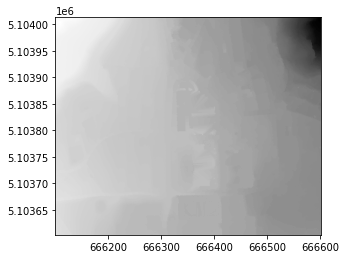

In [34]:
show(raster_dtm, cmap='Greys')

### 3. clip the street inside the area covered of the DTM

In [35]:
raster_dtm.bounds

BoundingBox(left=666100.6735466761, bottom=5103603.23583161, right=666600.6735466761, top=5104013.23583161)

In [36]:
minx = raster_dtm.bounds.left
maxx = raster_dtm.bounds.right
miny = raster_dtm.bounds.bottom
maxy = raster_dtm.bounds.top


![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/boudingbox.png)

In [37]:
from shapely.geometry import Polygon

In [38]:
bbox_raster_dtm = Polygon([[minx, miny], [maxx, miny], [maxx, maxy], [minx, maxy]])

In [39]:
geoseries_bbox_raster_dtm = gpd.GeoSeries([bbox_raster_dtm]).set_crs("EPSG:25832").to_crs("EPSG:4326")

In [40]:
geoseries_bbox_raster_dtm

0    POLYGON ((11.14767 46.06582, 11.15413 46.06570...
dtype: geometry

In [41]:
gdf_bbox_raster_dtm = gpd.GeoDataFrame(geometry=geoseries_bbox_raster_dtm)

In [42]:
gdf_bbox_raster_dtm

,geometry
0,"POLYGON ((11.14767 46.06582, 11.15413 46.06570..."


In [43]:
sommarive_street_inside_dtm = gpd.overlay(via_sommarive, gdf_bbox_raster_dtm, how='intersection')

In [44]:
sommarive_street_inside_dtm

,id,@id,highway,lit,maxspeed:type,name,surface,maxspeed,source:maxspeed,geometry
0,way/97004470,way/97004470,unclassified,yes,IT:urban,Via Sommarive,asphalt,None,None,"LINESTRING (11.15033 46.06577, 11.15033 46.065..."
1,way/382958545,way/382958545,residential,None,None,Via Sommarive,asphalt,50,sign,"LINESTRING (11.15058 46.06828, 11.15045 46.068..."


In [45]:
import folium

In [46]:
x = sommarive_street_inside_dtm.geometry.unary_union.centroid.x
y = sommarive_street_inside_dtm.geometry.unary_union.centroid.y

In [110]:
map = folium.Map([y,x], zoom_start=17)
folium.GeoJson(gdf_bbox_raster_dtm.to_json()).add_to(map)
folium.GeoJson(sommarive_street_inside_dtm.to_json()).add_to(map)
map

In [48]:
sommarive_street_inside_dtm.highway

0    unclassified
1     residential
Name: highway, dtype: object

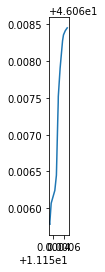

In [49]:
sommarive_street_inside_dtm[sommarive_street_inside_dtm.highway == 'unclassified'].plot()

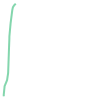

In [50]:
sommarive_street_inside_dtm[sommarive_street_inside_dtm.highway == 'unclassified'].geometry.values[0]

In [51]:
linestring_sommarive_street = sommarive_street_inside_dtm[sommarive_street_inside_dtm.highway == 'unclassified'].geometry.values[0]

### 4. extract the points of the street
we need to convert the points from WGS84 to ETRS89

In [52]:
import shapely
import pyproj
from shapely.ops import transform

In [53]:
wgs84 = pyproj.CRS('EPSG:4326')
crs_dtm = pyproj.CRS('EPSG:25832')
projection_transform = pyproj.Transformer.from_crs(wgs84, crs_dtm, always_xy=False).transform

In [54]:
def convert(x,y):
  p = shapely.geometry.Point(y,x)
  p = transform(projection_transform,p)
  return(p)

In [55]:
pointsx = []
pointsy = []
for coordinate in linestring_sommarive_street.coords:
  x = coordinate[0]
  y = coordinate[1]
  point = convert(x,y)
  pointsx.append(point.x)
  pointsy.append(point.y)

In [56]:
pointsx[0]

666306.4552006973

In [57]:
pointsy[0]

5103603.23091181

### 4. extract the altitude value for each points

In [58]:
import pandas as pd

In [59]:
#calculate the distance point-to-point
from shapely.geometry import Point,LineString
lengths = []
previousPoint = None
length = 0
for i in range(len(pointsx)):
  point = shapely.geometry.Point(pointsy[i],pointsx[i])
  if previousPoint is None:
    lengths.append(length)
  else:
    length = LineString([previousPoint,point]).length + length
    lengths.append(length)  
  previousPoint = point 


In [60]:
lengths

[0,
 3.951209709379636,
 32.831459096031196,
 52.98060861208776,
 76.0895772860392,
 92.85559295912803,
 165.21088895179275,
 186.20305604231848,
 194.89525293084407,
 237.7301320929318,
 279.66422694854015,
 288.77768975533206,
 295.6826859435214,
 301.98476544998357]

In [61]:
raster_dtm.count

1

In [62]:
data = raster_dtm.read(1)

In [63]:
data

array([[335., 335., 335., ..., 468., 469., 469.],
       [334., 334., 334., ..., 469., 469., 469.],
       [334., 334., 334., ..., 469., 469., 469.],
       ...,
       [357., 357., 357., ..., 400., 400., 401.],
       [356., 357., 357., ..., 400., 400., 400.],
       [356., 357., 357., ..., 400., 400., 400.]], dtype=float32)

In [64]:
rows,cols = rasterio.transform.rowcol(raster_dtm.transform,(pointsx),(pointsy))

In [65]:
values = []
for i in range(len(rows)):
  values.append(data[rows[i]-1][cols[i]-1]) 

In [66]:
values

[382.0,
 382.0,
 380.0,
 378.0,
 378.0,
 378.0,
 378.0,
 378.0,
 378.0,
 378.0,
 380.0,
 380.0,
 381.0,
 381.0]

In [67]:
sommarive_street_3d = pd.DataFrame()

In [68]:
sommarive_street_3d['value'] = values

In [69]:
sommarive_street_3d['length'] = lengths

In [70]:
sommarive_street_3d

,value,length
0,382.0,0.000000
1,382.0,3.951210
2,380.0,32.831459
3,378.0,52.980609
4,378.0,76.089577
5,378.0,92.855593
6,378.0,165.210889
7,378.0,186.203056
8,378.0,194.895253
9,378.0,237.730132


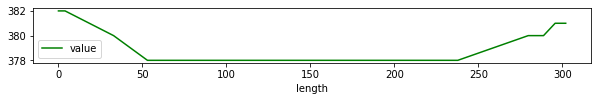

In [71]:
ax = sommarive_street_3d.plot(y='value',x="length",color='green',figsize=(10,1))

## find the area FBK in the WMS of municipality of Trento - layer “Carta Tecnica 1:2.000 alta risoluzione” and vectorize it

1. create a bounding box based on the FBK area in Povo
1. load the WMS of muncipality of Trento as rasterio on the size of the bounding box
1. vectorize the rasterio
---


### 1. create a bounding box based on the FBK area in Povo
.. we can use the same geojson extracted from OSM used on the lesson

In [72]:
fbk = gpd.read_file("https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/openstreetmap/boundary_fbk_povo.geojson")

In [73]:
bbox = fbk.geometry[0].bounds

In [74]:
bbox

(11.1505197, 46.0664359, 11.1530713, 46.0684635)

In [75]:
fbk.shape

(1, 10)

### 2. load the WMS of muncipality of Trento as rasterio on the size of the bounding box

In [76]:
from owslib.wms import WebMapService
import rasterio.crs

In [77]:
wms_trento = "http://webapps.comune.trento.it/ogc"

In [78]:
wms = WebMapService(wms_trento)

In [79]:
title="Carta Tecnica 1:2.000 alta risoluzione a colori"

In [80]:
wms.contents

OrderedDict([('ogc_services',
              <owslib.map.wms111.ContentMetadata at 0x7f8c70ef9ac8>),
             ('ortofoto2009',
              <owslib.map.wms111.ContentMetadata at 0x7f8c70ef9eb8>),
             ('ortofoto2015',
              <owslib.map.wms111.ContentMetadata at 0x7f8c70f12198>),
             ('ortofoto2016',
              <owslib.map.wms111.ContentMetadata at 0x7f8c70f12550>),
             ('ortofoto2019',
              <owslib.map.wms111.ContentMetadata at 0x7f8c70f128d0>),
             ('ortofoto2016infrarosso',
              <owslib.map.wms111.ContentMetadata at 0x7f8c70e9a048>),
             ('ortofoto2019infrarosso',
              <owslib.map.wms111.ContentMetadata at 0x7f8c70e9a128>),
             ('ct2000', <owslib.map.wms111.ContentMetadata at 0x7f8c70e9a208>),
             ('ct2000_colori',
              <owslib.map.wms111.ContentMetadata at 0x7f8c70e9a320>),
             ('carta_semplificata',
              <owslib.map.wms111.ContentMetadata at 0x7f8c70e9a

In [81]:
for content in wms.contents:
  layer = wms[content]
  if layer.title == title:
    break


In [82]:
content

'ct2000_colori'

In [83]:
layer.crsOptions

['EPSG:4326', 'EPSG:25832', 'EPSG:3857']

In [84]:
request = wms.getmap(
    layers=[content],
    srs='EPSG:4326',
    format='image/tiff',
    bbox=bbox,
    size=(1024,800)
    )

In [85]:
from rasterio import MemoryFile
from rasterio.plot import show
from rasterio import features

In [86]:
wms_image = MemoryFile(request).open()

In [87]:
wms_image.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1024, 'height': 800, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(2.4917968750015575e-06, 0.0, 11.1505197,
       0.0, -2.5344999999997646e-06, 46.0684635), 'tiled': False, 'interleave': 'pixel'}

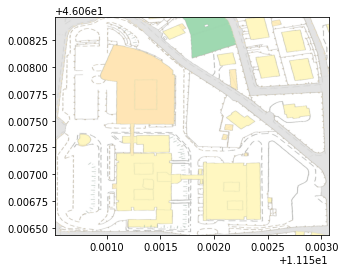

In [88]:
show(wms_image)

In [89]:
wms_image.count

3

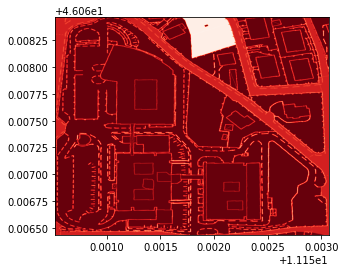

In [90]:
show((wms_image, 1), cmap='Reds')

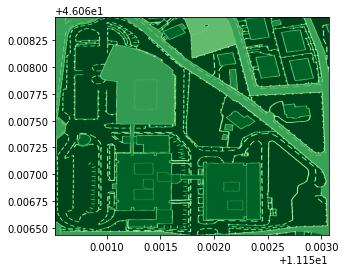

In [91]:
show((wms_image, 2), cmap='Greens')

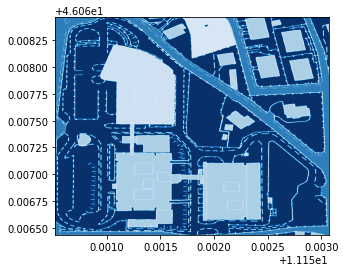

In [92]:
show((wms_image, 3), cmap='Blues')

In [93]:
blue = wms_image.read(3)
mask = blue != 255
shapes = features.shapes(blue, mask=mask)


In [94]:
from rasterio.features import shapes
image = wms_image.read(3) # first band
mask = blue != 255
results = (
  {'properties': {'raster_val': v}, 'geometry': s}
  for i, (s, v) 
    in enumerate(
      shapes(image, mask=mask, transform=wms_image.transform)))

In [95]:
geoms = list(results)

In [96]:
fbk_area_vector  = gpd.GeoDataFrame.from_features(geoms)

In [97]:
fbk_area_vector.shape

(78339, 2)

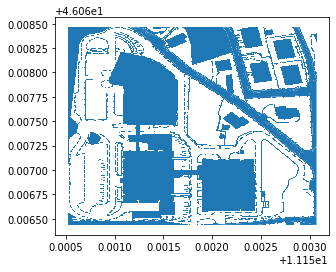

In [98]:
fbk_area_vector.plot()

FBK Buildings

North

https://www.openstreetmap.org/?mlat=46.06782&mlon=11.15156#map=19/46.06782/11.15156


West 

https://www.openstreetmap.org/?mlat=46.06689&mlon=11.15116#map=19/46.06689/11.15116

East

https://www.openstreetmap.org/?mlat=46.06684&mlon=11.15200#map=19/46.06684/11.15200

In [99]:
p_north = shapely.geometry.Point(11.15156,46.06782)

In [100]:
building_north = fbk_area_vector[fbk_area_vector.geometry.contains(p_north)]

In [101]:
building_north

,geometry,raster_val
42228,"POLYGON ((11.15107 46.06820, 11.15107 46.06820...",181.0


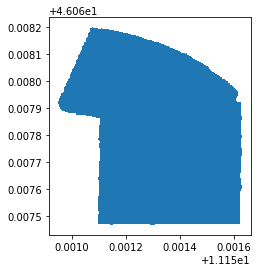

In [102]:
building_north.plot()

In [103]:
p_west = shapely.geometry.Point(11.15116,46.06689)
building_west = fbk_area_vector[fbk_area_vector.geometry.contains(p_west)]

In [104]:
p_east = shapely.geometry.Point(11.15200,46.06684)
building_east = fbk_area_vector[fbk_area_vector.geometry.contains(p_east)]

In [105]:
building_east

,geometry,raster_val
70295,"POLYGON ((11.15198 46.06710, 11.15198 46.06710...",193.0


In [106]:
x = building_east.geometry.centroid.x.values[0]
y = building_east.geometry.centroid.y.values[0]

In [107]:
import folium
map = folium.Map([y, x],zoom_start=19)
geojson_building_north = folium.features.GeoJson(building_north.to_json())
geojson_building_west = folium.features.GeoJson(building_west.to_json())
geojson_building_east = folium.features.GeoJson(building_east.to_json())
geojson_building_north.add_to(map)
geojson_building_west.add_to(map)
geojson_building_east.add_to(map)
map